# EDA: Hazelnut Real-World Images (`bad_nuts` + `real_nuts`)

This notebook performs **comprehensive exploratory data analysis** on two folders:
- `bad_nuts`: images with **green circle annotations** marking defects
- `real_nuts`: the same or similar images **without annotations**

**What you will get:**
- File counts and formats for both folders
- Image sizes, aspect ratios, modes
- Color statistics and brightness/contrast distributions
- Blur/quality metrics
- Simple duplicate detection
- Heuristic detection of green-circle annotations
- **Exported defect crops + masks** suitable for production ML


## 0. Setup

Optionally, you can download the Google Drive folder with `gdown` (uncomment):

```bash
pip install gdown

gdown --folder "https://drive.google.com/drive/folders/19kQFj13vp8gyyBTrKysH1XZGEQUG4uxd"
```

Set `BAD_NUTS_DIR` and `REAL_NUTS_DIR` below (or use environment variables).


In [44]:
from pathlib import Path
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from matplotlib.colors import rgb_to_hsv

try:
    from skimage.filters import laplace, threshold_otsu, gaussian
    from skimage.color import rgb2gray
    from skimage.measure import label, regionprops
    from skimage.morphology import remove_small_objects, remove_small_holes, disk, opening
    from skimage.segmentation import watershed
    from skimage.feature import peak_local_max
    SKIMAGE_OK = True
except Exception:
    SKIMAGE_OK = False

try:
    from scipy import ndimage as ndi
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

SEED = 7
random.seed(SEED)
np.random.seed(SEED)

BAD_NUTS_DIR = Path(os.environ.get("BAD_NUTS_DIR", "/path/to/bad_nuts")).expanduser()
REAL_NUTS_DIR = Path(os.environ.get("REAL_NUTS_DIR", "/path/to/real_nuts")).expanduser()

if not BAD_NUTS_DIR.exists():
    raise FileNotFoundError(f"BAD_NUTS_DIR not found: {BAD_NUTS_DIR}")
if not REAL_NUTS_DIR.exists():
    raise FileNotFoundError(f"REAL_NUTS_DIR not found: {REAL_NUTS_DIR}")

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


## 1. Discover files

In [45]:
EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

def list_images(root):
    return sorted([p for p in root.rglob("*") if p.suffix.lower() in EXTS])

bad_paths = list_images(BAD_NUTS_DIR)
real_paths = list_images(REAL_NUTS_DIR)

print(f"bad_nuts images: {len(bad_paths)}")
print(f"real_nuts images: {len(real_paths)}")

ext_counts = pd.concat([
    pd.DataFrame({
        "ext": [p.suffix.lower() for p in bad_paths],
        "dataset": "bad_nuts",
    }),
    pd.DataFrame({
        "ext": [p.suffix.lower() for p in real_paths],
        "dataset": "real_nuts",
    }),
], ignore_index=True)

ext_counts = ext_counts.groupby(["dataset", "ext"]).size().reset_index(name="count")
ext_counts


bad_nuts images: 20
real_nuts images: 20


dataset   ext  count
0   bad_nuts  .jpg     20
1  real_nuts  .jpg     20

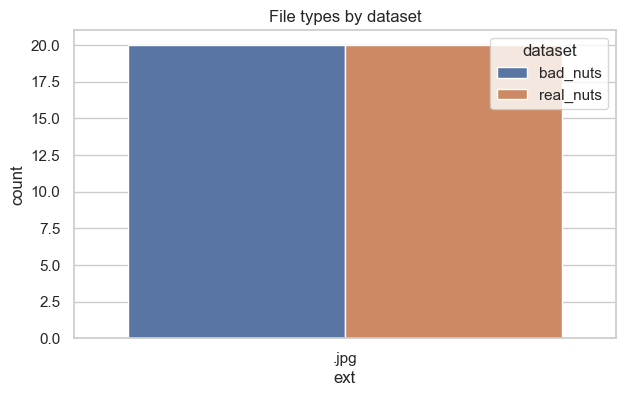

In [46]:
plt.figure(figsize=(7, 4))
sns.barplot(data=ext_counts, x="ext", y="count", hue="dataset")
plt.title("File types by dataset")
plt.show()


## 2. Basic image stats

In [47]:
def get_image_info(path, dataset):
    img = Image.open(path)
    w, h = img.size
    return {
        "path": path,
        "dataset": dataset,
        "width": w,
        "height": h,
        "aspect": w / h,
        "mode": img.mode,
        "filesize_kb": path.stat().st_size / 1024.0,
    }

rows = []
for p in tqdm(bad_paths, desc="bad_nuts info"):
    rows.append(get_image_info(p, "bad_nuts"))
for p in tqdm(real_paths, desc="real_nuts info"):
    rows.append(get_image_info(p, "real_nuts"))

info_df = pd.DataFrame(rows)
info_df.head()


real_nuts info: 100%|██████████| 20/20 [00:00<00:00, 2491.27it/s]


path   dataset  width  height    aspect mode  \
0  data/bad_nuts/IMG_1280.JPG  bad_nuts   4000    3000  1.333333  RGB   
1  data/bad_nuts/IMG_1281.JPG  bad_nuts   4000    3000  1.333333  RGB   
2  data/bad_nuts/IMG_1282.JPG  bad_nuts   4000    3000  1.333333  RGB   
3  data/bad_nuts/IMG_1283.JPG  bad_nuts   4000    3000  1.333333  RGB   
4  data/bad_nuts/IMG_1284.JPG  bad_nuts   4000    3000  1.333333  RGB   

   filesize_kb  
0  2151.592773  
1  3025.532227  
2  2808.380859  
3  3134.559570  
4  2049.379883

In [48]:
info_df.groupby("dataset")[["width", "height", "aspect", "filesize_kb"]].describe()


width                                                      height  \
          count    mean  std     min     25%     50%     75%     max  count   
dataset                                                                       
bad_nuts   20.0  4000.0  0.0  4000.0  4000.0  4000.0  4000.0  4000.0   20.0   
real_nuts  20.0  4000.0  0.0  4000.0  4000.0  4000.0  4000.0  4000.0   20.0   

                   ...    aspect           filesize_kb               \
             mean  ...       75%       max       count         mean   
dataset            ...                                                
bad_nuts   3000.0  ...  1.333333  1.333333        20.0  2817.988281   
real_nuts  3000.0  ...  1.333333  1.333333        20.0  2803.394873   

                                                                           \
                  std          min          25%          50%          75%   
dataset                                                                     
bad_nuts   313.193734  2049.379883  2709.830078  2937.871094  3009.491455   
real_nuts  319.862877  2049.379883  2709.830078  2871.166992  2997.374023   

                        
                   max  
dataset                 
bad_nuts   3196.632812  
real_nuts  3196.632812  

[2 rows x 32 columns]

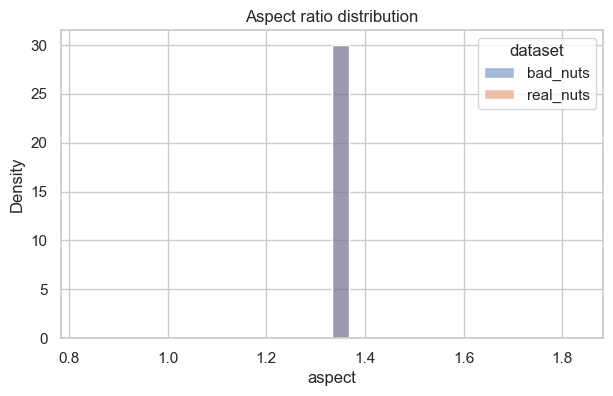

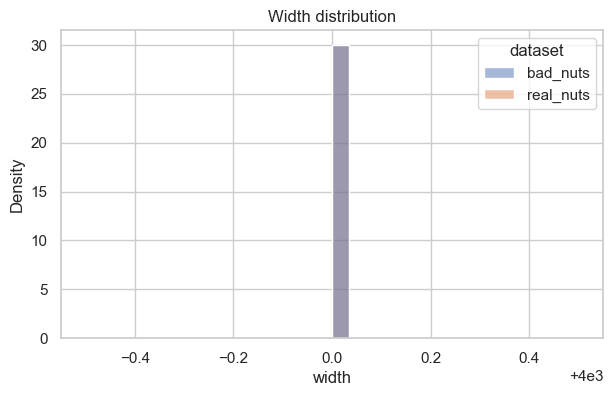

In [49]:
plt.figure(figsize=(7, 4))
sns.histplot(info_df, x="aspect", hue="dataset", bins=30, stat="density", common_norm=False)
plt.title("Aspect ratio distribution")
plt.show()

plt.figure(figsize=(7, 4))
sns.histplot(info_df, x="width", hue="dataset", bins=30, stat="density", common_norm=False)
plt.title("Width distribution")
plt.show()


## 3. Color and intensity stats

In [50]:
def load_rgb(path, max_size=512):
    img = Image.open(path).convert("RGB")
    if max(img.size) > max_size:
        scale = max_size / max(img.size)
        img = img.resize((int(img.size[0] * scale), int(img.size[1] * scale)), Image.BILINEAR)
    return np.asarray(img, dtype=np.float32) / 255.0

stats = []
for p in tqdm(bad_paths, desc="bad_nuts color"):
    arr = load_rgb(p)
    stats.append({
        "path": p,
        "dataset": "bad_nuts",
        "r_mean": arr[..., 0].mean(),
        "g_mean": arr[..., 1].mean(),
        "b_mean": arr[..., 2].mean(),
        "brightness": arr.mean(),
        "contrast": arr.std(),
    })
for p in tqdm(real_paths, desc="real_nuts color"):
    arr = load_rgb(p)
    stats.append({
        "path": p,
        "dataset": "real_nuts",
        "r_mean": arr[..., 0].mean(),
        "g_mean": arr[..., 1].mean(),
        "b_mean": arr[..., 2].mean(),
        "brightness": arr.mean(),
        "contrast": arr.std(),
    })

color_df = pd.DataFrame(stats)
color_df.groupby("dataset").describe()


real_nuts color: 100%|██████████| 20/20 [00:04<00:00,  4.85it/s]


r_mean                                                              \
           count      mean       std       min       25%       50%       75%   
dataset                                                                        
bad_nuts    20.0  0.670118  0.050663  0.560943  0.648250  0.669692  0.701822   
real_nuts   20.0  0.670823  0.050473  0.560943  0.651615  0.673096  0.701822   

                    g_mean            ... brightness           contrast  \
                max  count      mean  ...        75%       max    count   
dataset                               ...                                 
bad_nuts   0.756123   20.0  0.319598  ...   0.383461  0.424989     20.0   
real_nuts  0.756123   20.0  0.318954  ...   0.383461  0.424989     20.0   

                                                                                
               mean      std       min       25%       50%       75%       max  
dataset                                                                         
bad_nuts   0.286685  0.01924  0.249589  0.277875  0.292688  0.299941  0.314039  
real_nuts  0.287022  0.01896  0.251640  0.279882  0.292688  0.299941  0.314039  

[2 rows x 40 columns]

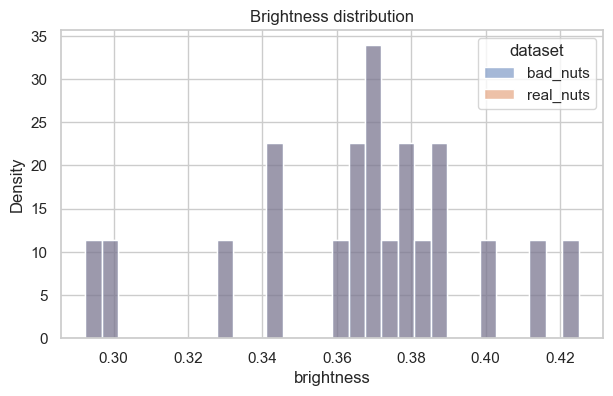

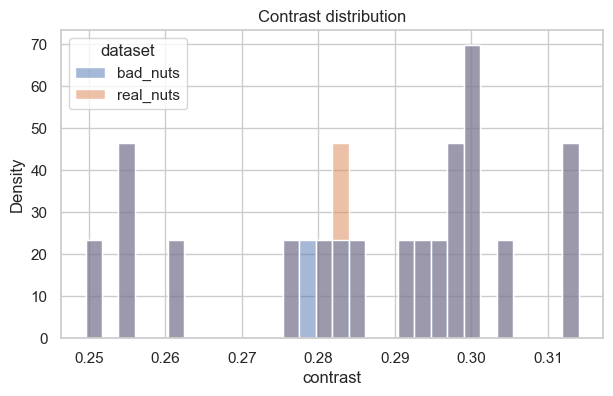

In [51]:
plt.figure(figsize=(7, 4))
sns.histplot(color_df, x="brightness", hue="dataset", bins=30, stat="density", common_norm=False)
plt.title("Brightness distribution")
plt.show()

plt.figure(figsize=(7, 4))
sns.histplot(color_df, x="contrast", hue="dataset", bins=30, stat="density", common_norm=False)
plt.title("Contrast distribution")
plt.show()


## 4. Heuristic detection of green annotations (bad_nuts only)

green ratio: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s]


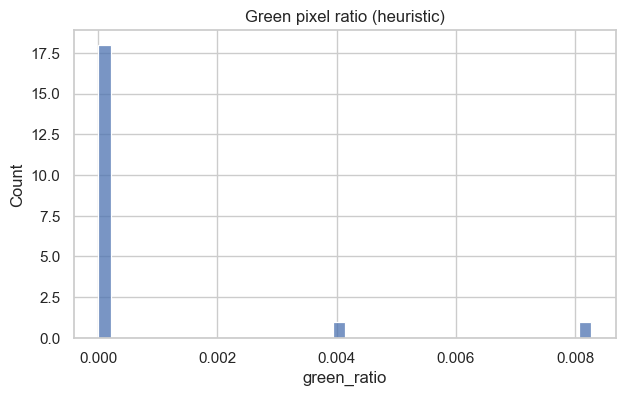

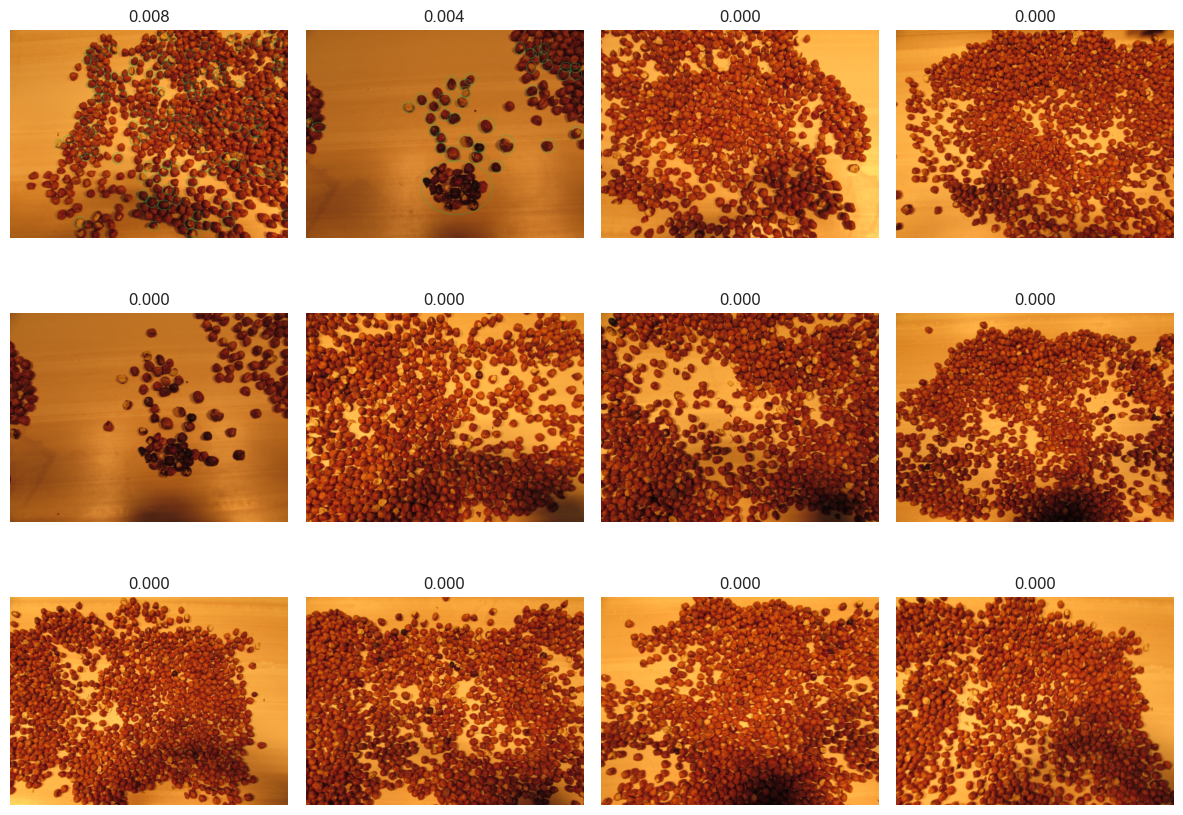

In [52]:
def green_ratio(arr):
    hsv = rgb_to_hsv(arr)
    h = hsv[..., 0]
    s = hsv[..., 1]
    v = hsv[..., 2]
    mask = (h > 0.25) & (h < 0.45) & (s > 0.35) & (v > 0.2)
    return mask.mean()

rows = []
for p in tqdm(bad_paths, desc="green ratio"):
    arr = load_rgb(p)
    rows.append({"path": p, "green_ratio": green_ratio(arr)})

green_df = pd.DataFrame(rows)

plt.figure(figsize=(7, 4))
sns.histplot(green_df["green_ratio"], bins=40)
plt.title("Green pixel ratio (heuristic)")
plt.show()

n_show = min(12, len(green_df))
top = green_df.sort_values("green_ratio", ascending=False).head(n_show)
cols = 4
rows = int(np.ceil(n_show / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = np.array(axes).reshape(-1)
for ax, (_, row) in zip(axes, top.iterrows()):
    img = load_rgb(row["path"], max_size=512)
    ax.imshow(img)
    ax.set_title(f"{row['green_ratio']:.3f}")
    ax.axis("off")
for ax in axes[n_show:]:
    ax.axis("off")
plt.tight_layout()
plt.show()


## 5. Image quality (blur/edges)

real_nuts blur: 100%|██████████| 20/20 [00:02<00:00,  7.07it/s]


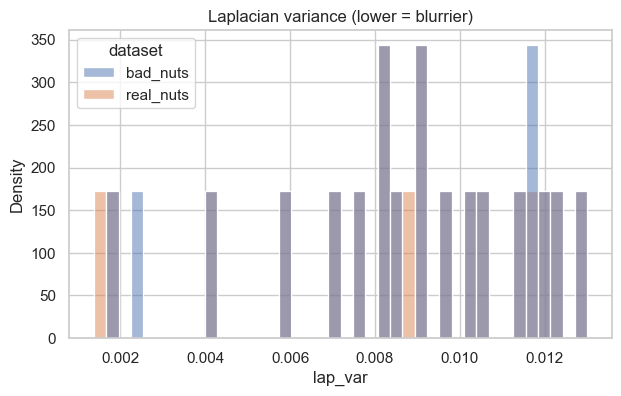

In [53]:
if SKIMAGE_OK:
    blur_rows = []
    for p in tqdm(bad_paths, desc="bad_nuts blur"):
        arr = load_rgb(p)
        gray = rgb2gray(arr)
        lap = laplace(gray)
        blur_rows.append({"path": p, "dataset": "bad_nuts", "lap_var": np.var(lap)})
    for p in tqdm(real_paths, desc="real_nuts blur"):
        arr = load_rgb(p)
        gray = rgb2gray(arr)
        lap = laplace(gray)
        blur_rows.append({"path": p, "dataset": "real_nuts", "lap_var": np.var(lap)})

    blur_df = pd.DataFrame(blur_rows)
    plt.figure(figsize=(7, 4))
    sns.histplot(blur_df, x="lap_var", hue="dataset", bins=40, stat="density", common_norm=False)
    plt.title("Laplacian variance (lower = blurrier)")
    plt.show()
else:
    print("skimage not available; skipping blur metric")


## 6. Duplicate detection (simple perceptual hash)

hashing: 100%|██████████| 40/40 [00:04<00:00,  9.68it/s]


Potential duplicate groups: 18


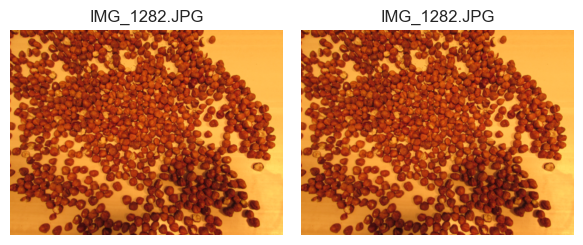

In [54]:
def average_hash(img, hash_size=8):
    img = img.convert("L").resize((hash_size, hash_size), Image.BILINEAR)
    arr = np.asarray(img)
    return (arr > arr.mean()).astype(np.uint8).flatten()

hashes = {}
for p in tqdm(bad_paths + real_paths, desc="hashing"):
    img = Image.open(p)
    h = average_hash(img)
    key = ''.join(h.astype(str))
    hashes.setdefault(key, []).append(p)

# Show groups with duplicates (exact same hash)
dups = {k: v for k, v in hashes.items() if len(v) > 1}
print(f"Potential duplicate groups: {len(dups)}")

if dups:
    first = next(iter(dups.values()))
    n_show = min(6, len(first))
    fig, axes = plt.subplots(1, n_show, figsize=(n_show * 3, 3))
    axes = np.array(axes).reshape(-1)
    for ax, path in zip(axes, first[:n_show]):
        ax.imshow(load_rgb(path))
        ax.set_title(path.name)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


## 7. Random sample grid

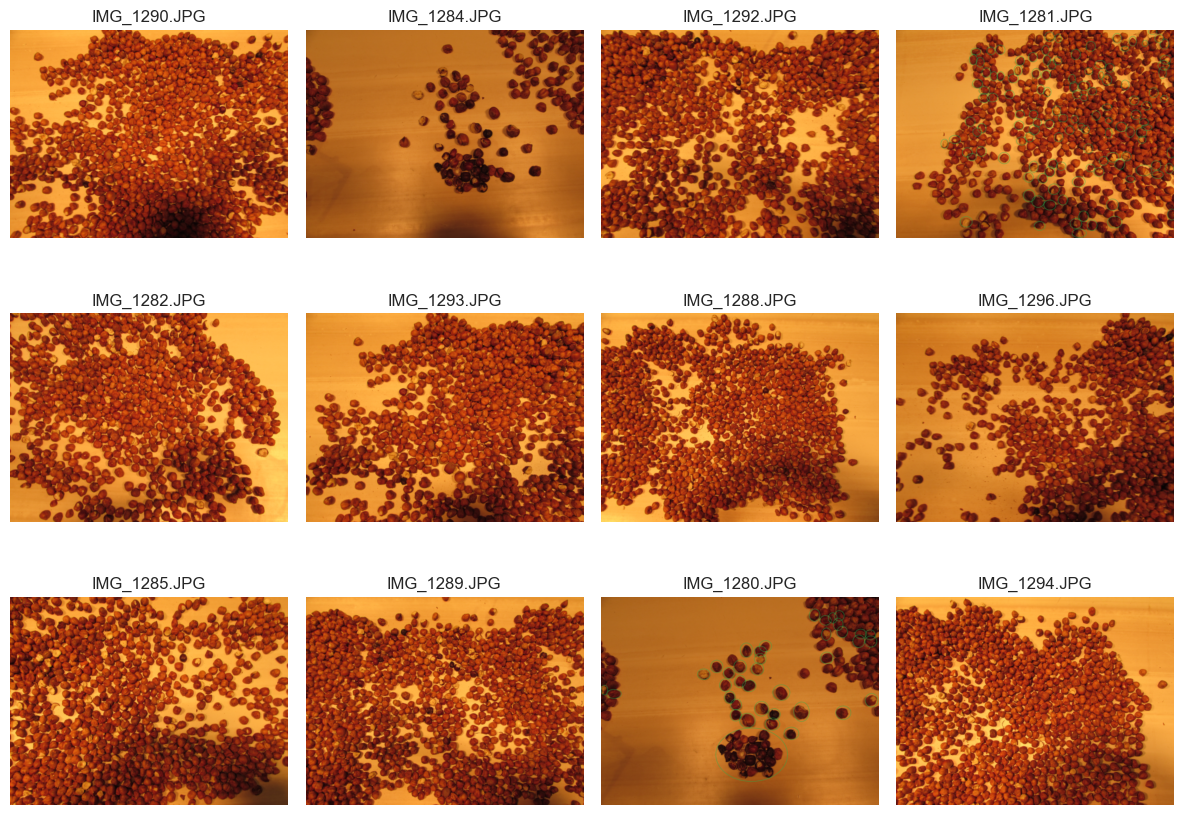

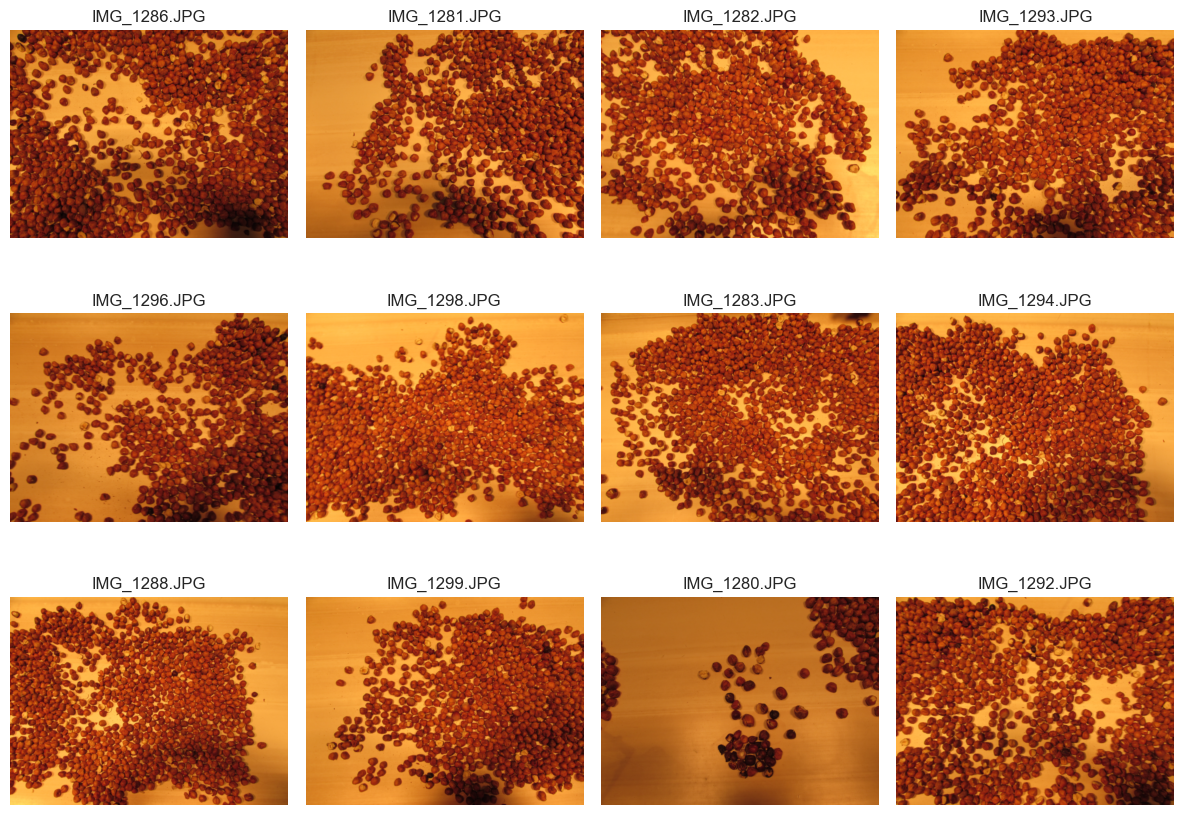

In [55]:
def show_random_grid(paths, title, n_show=12):
    n_show = min(n_show, len(paths))
    picks = random.sample(paths, n_show)
    cols = 4
    rows = int(np.ceil(n_show / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = np.array(axes).reshape(-1)
    for ax, path in zip(axes, picks):
        ax.imshow(load_rgb(path))
        ax.set_title(path.name)
        ax.axis("off")
    for ax in axes[n_show:]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_random_grid(bad_paths, "bad_nuts samples")
show_random_grid(real_paths, "real_nuts samples")


## 8. Build labeled defect crops + masks from green circles

**Production-friendly guidance**
- If you want *classification*, use **cropped patches** around the defect (smaller files, faster training).
- If you want *segmentation/localization*, keep **full images + masks** (better for adjacent nuts).
- Given many nuts are adjacent, **smaller, tighter crops** reduce label noise from neighbors.

**Clean crops option (recommended):**
- We match each `bad_nuts` image to its corresponding `real_nuts` image.
- Crops are taken from the **real (uncircled)** image, using the circle location as the label.
- This avoids the model learning the green annotation artifact.

This section exports:
- `defect_crops_clean/` (crops from real_nuts, preferred)
- `defect_crops/` (fallback annotated crops)
- `defect_masks/` (binary masks aligned to crops)
- `defect_full_masks/` (full-size masks)
- `defect_crops_manifest.csv`


In [56]:
OUTPUT_DIR = Path("data/real_nuts_ml")
CROP_SCALE = 1.6   # tighter (1.2-1.6) reduces neighbor leakage
OUT_SIZE = 256     # resize crop to fixed size; set to None to keep original crop size
DETECT_MAX_SIZE = 1024  # resize for detection only; None for full-res detection
MIN_COMPONENT_AREA = 30

USE_REAL_FOR_CROPS = True  # use real_nuts images for clean crops when available

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / "defect_crops").mkdir(exist_ok=True)
(OUTPUT_DIR / "defect_crops_clean").mkdir(exist_ok=True)
(OUTPUT_DIR / "defect_masks").mkdir(exist_ok=True)
(OUTPUT_DIR / "defect_full_masks").mkdir(exist_ok=True)


In [57]:
def build_real_mapping(bad_paths, real_paths):
    real_by_name = {p.name: p for p in real_paths}
    real_sorted = sorted(real_paths)
    bad_sorted = sorted(bad_paths)

    def try_numeric_offset(name, offset):
        stem, ext = Path(name).stem, Path(name).suffix
        num = ''.join(ch for ch in stem if ch.isdigit())
        if not num:
            return None
        prefix = stem[: len(stem) - len(num)]
        try:
            new_num = int(num) + offset
        except ValueError:
            return None
        candidate = f"{prefix}{new_num}{ext}"
        return candidate

    mapping = {}
    for i, bp in enumerate(bad_sorted):
        # 1) exact name
        if bp.name in real_by_name:
            mapping[bp] = real_by_name[bp.name]
            continue
        # 2) try off-by-one numeric suffix
        for off in (1, -1):
            cand = try_numeric_offset(bp.name, off)
            if cand and cand in real_by_name:
                mapping[bp] = real_by_name[cand]
                break
        if bp in mapping:
            continue
        # 3) fallback: positional mapping by sorted order
        if i < len(real_sorted):
            mapping[bp] = real_sorted[i]

    return mapping

real_map = build_real_mapping(bad_paths, real_paths)

matched = sum(1 for k, v in real_map.items() if v is not None)
unmatched = len(bad_paths) - matched
print(f"Mapped {matched} bad_nuts -> real_nuts, unmatched: {unmatched}")

# Show a few example mappings
for bp in list(real_map.keys())[:5]:
    print(bp.name, "->", real_map[bp].name if real_map[bp] else None)


Mapped 20 bad_nuts -> real_nuts, unmatched: 0
IMG_1280.JPG -> IMG_1280.JPG
IMG_1281.JPG -> IMG_1281.JPG
IMG_1282.JPG -> IMG_1282.JPG
IMG_1283.JPG -> IMG_1283.JPG
IMG_1284.JPG -> IMG_1284.JPG


In [58]:
def green_mask_from_rgb(arr):
    hsv = rgb_to_hsv(arr)
    h = hsv[..., 0]
    s = hsv[..., 1]
    v = hsv[..., 2]
    return (h > 0.25) & (h < 0.45) & (s > 0.35) & (v > 0.2)


def find_green_components(img):
    # Returns list of (cx, cy, radius)
    if DETECT_MAX_SIZE is not None and max(img.size) > DETECT_MAX_SIZE:
        scale = DETECT_MAX_SIZE / max(img.size)
        small = img.resize((int(img.size[0] * scale), int(img.size[1] * scale)), Image.BILINEAR)
    else:
        scale = 1.0
        small = img

    arr = np.asarray(small.convert("RGB"), dtype=np.float32) / 255.0
    mask = green_mask_from_rgb(arr)

    circles = []
    if SKIMAGE_OK:
        lab = label(mask.astype(np.uint8))
        for region in regionprops(lab):
            if region.area < MIN_COMPONENT_AREA:
                continue
            minr, minc, maxr, maxc = region.bbox
            cx = (minc + maxc) / 2.0
            cy = (minr + maxr) / 2.0
            radius = max(maxc - minc, maxr - minr) / 2.0
            circles.append((cx / scale, cy / scale, radius / scale))
    else:
        ys, xs = np.where(mask)
        if len(xs) > 0:
            minx, maxx = xs.min(), xs.max()
            miny, maxy = ys.min(), ys.max()
            cx = (minx + maxx) / 2.0
            cy = (miny + maxy) / 2.0
            radius = max(maxx - minx, maxy - miny) / 2.0
            circles.append((cx / scale, cy / scale, radius / scale))

    return circles


def crop_square(img, cx, cy, size):
    size = int(size)
    left = int(cx - size / 2)
    top = int(cy - size / 2)
    right = left + size
    bottom = top + size

    pad_left = max(0, -left)
    pad_top = max(0, -top)
    pad_right = max(0, right - img.size[0])
    pad_bottom = max(0, bottom - img.size[1])

    if any([pad_left, pad_top, pad_right, pad_bottom]):
        img = Image.fromarray(np.pad(
            np.asarray(img),
            ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
            mode="constant",
            constant_values=0,
        ))
        left += pad_left
        top += pad_top
        right += pad_left
        bottom += pad_top

    return img.crop((left, top, right, bottom))


def circle_mask(shape, cx, cy, radius):
    h, w = shape
    yy, xx = np.ogrid[:h, :w]
    return ((xx - cx) ** 2 + (yy - cy) ** 2 <= radius ** 2).astype(np.uint8)


In [59]:
manifest = []

for path in tqdm(bad_paths, desc="exporting crops"):
    bad_img = Image.open(path).convert("RGB")
    circles = find_green_components(bad_img)
    if not circles:
        continue

    # full-size mask (combine all circles)
    full_mask = np.zeros((bad_img.size[1], bad_img.size[0]), dtype=np.uint8)
    for (cx, cy, r) in circles:
        full_mask |= circle_mask(full_mask.shape, cx, cy, r)

    full_mask_path = OUTPUT_DIR / "defect_full_masks" / f"{path.stem}_mask.png"
    Image.fromarray(full_mask * 255).save(full_mask_path)

    # Choose crop source (real image when available)
    real_path = real_map.get(path)
    if USE_REAL_FOR_CROPS and real_path is not None:
        crop_source = Image.open(real_path).convert("RGB")
        crop_source_label = "clean"
    else:
        crop_source = bad_img
        crop_source_label = "annotated"

    for i, (cx, cy, r) in enumerate(circles):
        crop_size = max(32, int(2 * r * CROP_SCALE))
        crop = crop_square(crop_source, cx, cy, crop_size)

        crop_mask = circle_mask((crop.size[1], crop.size[0]), crop_size / 2, crop_size / 2, r)
        crop_mask_img = Image.fromarray(crop_mask * 255)

        if OUT_SIZE is not None:
            crop = crop.resize((OUT_SIZE, OUT_SIZE), Image.BILINEAR)
            crop_mask_img = crop_mask_img.resize((OUT_SIZE, OUT_SIZE), Image.NEAREST)

        crop_name = f"{path.stem}_defect_{i:02d}.jpg"
        mask_name = f"{path.stem}_defect_{i:02d}_mask.png"

        if crop_source_label == "clean":
            crop_path = OUTPUT_DIR / "defect_crops_clean" / crop_name
        else:
            crop_path = OUTPUT_DIR / "defect_crops" / crop_name
        mask_path = OUTPUT_DIR / "defect_masks" / mask_name

        crop.save(crop_path, quality=92)
        crop_mask_img.save(mask_path)

        manifest.append({
            "source_path": str(path),
            "real_path": str(real_path) if real_path is not None else "",
            "crop_path": str(crop_path),
            "mask_path": str(mask_path),
            "full_mask_path": str(full_mask_path),
            "crop_source": crop_source_label,
            "cx": cx,
            "cy": cy,
            "radius": r,
            "crop_size": crop_size,
            "out_size": OUT_SIZE,
        })

manifest_df = pd.DataFrame(manifest)
manifest_df.to_csv(OUTPUT_DIR / "defect_crops_manifest.csv", index=False)
print(f"Saved {len(manifest_df)} defect crops to {OUTPUT_DIR}")


exporting crops: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]

Saved 104 defect crops to data/real_nuts_ml


## 9. Auto-segmentation: isolate individual nuts (experimental)

This section attempts to **segment individual nuts** from the real images and label them as defect/good
based on overlap with the defect mask derived from the green circles. This is useful when you want a
**per-nut classifier** in addition to context patches.

Notes:
- This is heuristic and depends on lighting/background. Tune thresholds if needed.
- If `scipy` is not available, it will fall back to connected components (less accurate).


In [ ]:
if not SKIMAGE_OK:
    raise ImportError("scikit-image is required for auto-segmentation")

NUT_OUT_SIZE = 256
SEGMENT_MAX_SIZE = 1024
MIN_NUT_AREA = 4000      # in resized pixels; tune per dataset
MIN_HOLE_AREA = 2000
DEFECT_OVERLAP = 0.02    # fraction of nut mask overlapping defect mask
NUT_PAD = 8

(OUTPUT_DIR / "nut_crops" / "defect").mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / "nut_crops" / "good").mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / "nut_masks").mkdir(parents=True, exist_ok=True)


In [ ]:
def resize_for_seg(img, max_size=SEGMENT_MAX_SIZE):
    if max(img.size) <= max_size:
        return img, 1.0
    scale = max_size / max(img.size)
    new_size = (int(img.size[0] * scale), int(img.size[1] * scale))
    return img.resize(new_size, Image.BILINEAR), scale


def get_foreground_mask(img):
    # Returns binary mask of likely nuts (foreground)
    arr = np.asarray(img, dtype=np.float32) / 255.0
    gray = rgb2gray(arr)
    blur = gaussian(gray, sigma=1)
    thr = threshold_otsu(blur)
    fg = blur < thr

    # If corners are mostly foreground, invert
    h, w = fg.shape
    m = max(4, int(0.05 * min(h, w)))
    corners = np.r_[fg[:m, :m].ravel(), fg[:m, -m:].ravel(), fg[-m:, :m].ravel(), fg[-m:, -m:].ravel()]
    if corners.mean() > 0.5:
        fg = ~fg

    fg = opening(fg, disk(3))
    fg = remove_small_objects(fg, min_size=MIN_NUT_AREA)
    fg = remove_small_holes(fg, area_threshold=MIN_HOLE_AREA)
    return fg


def segment_nuts(img):
    img_small, scale = resize_for_seg(img)
    fg = get_foreground_mask(img_small)

    if SCIPY_OK:
        distance = ndi.distance_transform_edt(fg)
        peaks = peak_local_max(distance, footprint=np.ones((25, 25)), labels=fg)
        markers = np.zeros_like(distance, dtype=np.int32)
        for i, (r, c) in enumerate(peaks, start=1):
            markers[r, c] = i
        labels = watershed(-distance, markers, mask=fg)
    else:
        labels = label(fg)

    return labels, scale, img_small


def crop_with_pad(img, bbox, pad=NUT_PAD):
    minr, minc, maxr, maxc = bbox
    minr = max(minr - pad, 0)
    minc = max(minc - pad, 0)
    maxr = min(maxr + pad, img.size[1])
    maxc = min(maxc + pad, img.size[0])
    return img.crop((minc, minr, maxc, maxr))


In [ ]:
nut_manifest = []

for bad_path in tqdm(bad_paths, desc="nut segmentation"):
    bad_img = Image.open(bad_path).convert("RGB")
    circles = find_green_components(bad_img)
    if not circles:
        continue

    # Build full-size defect mask in bad_img coordinates
    full_mask = np.zeros((bad_img.size[1], bad_img.size[0]), dtype=np.uint8)
    for (cx, cy, r) in circles:
        full_mask |= circle_mask(full_mask.shape, cx, cy, r)

    # Use real image for segmentation/crops if available
    real_path = real_map.get(bad_path)
    if real_path is None:
        continue
    real_img = Image.open(real_path).convert("RGB")

    # If sizes differ, resize mask to real image size
    if real_img.size != bad_img.size:
        full_mask = Image.fromarray((full_mask * 255).astype(np.uint8))
        full_mask = full_mask.resize(real_img.size, Image.NEAREST)
        full_mask = (np.asarray(full_mask) > 0).astype(np.uint8)

    labels, scale, img_small = segment_nuts(real_img)
    if labels.max() == 0:
        continue

    # Resize full_mask to match segmentation size
    if scale != 1.0:
        mask_small = Image.fromarray((full_mask * 255).astype(np.uint8)).resize(img_small.size, Image.NEAREST)
        mask_small = (np.asarray(mask_small) > 0).astype(np.uint8)
    else:
        mask_small = full_mask

    for region in regionprops(labels):
        if region.area < MIN_NUT_AREA:
            continue
        minr, minc, maxr, maxc = region.bbox
        # Map bbox back to original scale
        if scale != 1.0:
            minr_o = int(minr / scale)
            minc_o = int(minc / scale)
            maxr_o = int(maxr / scale)
            maxc_o = int(maxc / scale)
        else:
            minr_o, minc_o, maxr_o, maxc_o = minr, minc, maxr, maxc

        # Overlap between nut mask and defect mask (in small scale)
        nut_mask = region.image.astype(bool)
        defect_crop = mask_small[minr:maxr, minc:maxc].astype(bool)
        overlap = (nut_mask & defect_crop).sum() / max(1, nut_mask.sum())
        label_name = "defect" if overlap >= DEFECT_OVERLAP else "good"

        crop = crop_with_pad(real_img, (minr_o, minc_o, maxr_o, maxc_o))
        if NUT_OUT_SIZE is not None:
            crop = crop.resize((NUT_OUT_SIZE, NUT_OUT_SIZE), Image.BILINEAR)

        out_name = f"{bad_path.stem}_nut_{region.label:02d}.jpg"
        out_path = OUTPUT_DIR / "nut_crops" / label_name / out_name
        crop.save(out_path, quality=92)

        nut_manifest.append({
            "bad_path": str(bad_path),
            "real_path": str(real_path),
            "label": label_name,
            "overlap": overlap,
            "bbox": [minr_o, minc_o, maxr_o, maxc_o],
            "crop_path": str(out_path),
        })

nut_manifest_df = pd.DataFrame(nut_manifest)
manifest_path = OUTPUT_DIR / "nut_crops_manifest.csv"
nut_manifest_df.to_csv(manifest_path, index=False)
print(f"Saved {len(nut_manifest_df)} nut crops to {manifest_path}")


In [ ]:
# Visualize segmentation on a sample image
sample_bad = random.choice(bad_paths)
sample_real = real_map.get(sample_bad)
if sample_real is not None:
    img = Image.open(sample_real).convert("RGB")
    labels, scale, img_small = segment_nuts(img)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_small)
    plt.imshow(labels, alpha=0.4)
    plt.title("Auto-segmented nuts (overlay)")
    plt.axis("off")
    plt.show()


## 10. Export a summary CSV (optional)


In [60]:
summary_df = info_df.merge(color_df, on=["path", "dataset"])
summary_df = summary_df.merge(green_df, on="path", how="left")

summary_path = Path("eda_hazelnut_real_summary.csv")
summary_df.to_csv(summary_path, index=False)
print(f"Saved {summary_path}")


Saved eda_hazelnut_real_summary.csv
